<a href="https://colab.research.google.com/github/inamsatti/ElectricVehicles/blob/main/Electric_car_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle


**Importing Libriries**

In [3]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
import pickle
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn

**Dataset loading**

In [4]:
path = kagglehub.dataset_download("kkhandekar/cheapest-electric-cars/versions/1")
print("Path to dataset files:", path)
df1 = pd.read_csv("/root/.cache/kagglehub/datasets/kkhandekar/cheapest-electric-cars/versions/1/Cheapestelectriccars-EVDatabase.csv")

df1.head()


100%|██████████| 5.25k/5.25k [00:00<00:00, 1.97MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/kkhandekar/cheapest-electric-cars/versions/1


,Name,Subtitle,Acceleration,TopSpeed,Range,Efficiency,FastChargeSpeed,Drive,NumberofSeats,PriceinGermany,PriceinUK
0,Opel Ampera-e,Battery Electric Vehicle | 58 kWh,7.3 sec,150 km/h,335 km,173 Wh/km,210 km/h,Front Wheel Drive,5,"€42,990",NaN
1,Renault Kangoo Maxi ZE 33,Battery Electric Vehicle | 31 kWh,22.4 sec,130 km/h,160 km,194 Wh/km,-,Front Wheel Drive,5,NaN,"£31,680"
2,Nissan Leaf,Battery Electric Vehicle | 36 kWh,7.9 sec,144 km/h,220 km,164 Wh/km,230 km/h,Front Wheel Drive,5,"€29,990","£25,995"
3,Audi e-tron Sportback 55 quattro,Battery Electric Vehicle | 86.5 kWh,5.7 sec,200 km/h,375 km,231 Wh/km,600 km/h,All Wheel Drive,5,NaN,"£79,900"
4,Porsche Taycan Turbo S,Battery Electric Vehicle | 83.7 kWh,2.8 sec,260 km/h,390 km,215 Wh/km,860 km/h,All Wheel Drive,4,"€186,336","£138,830"


<Axes: >

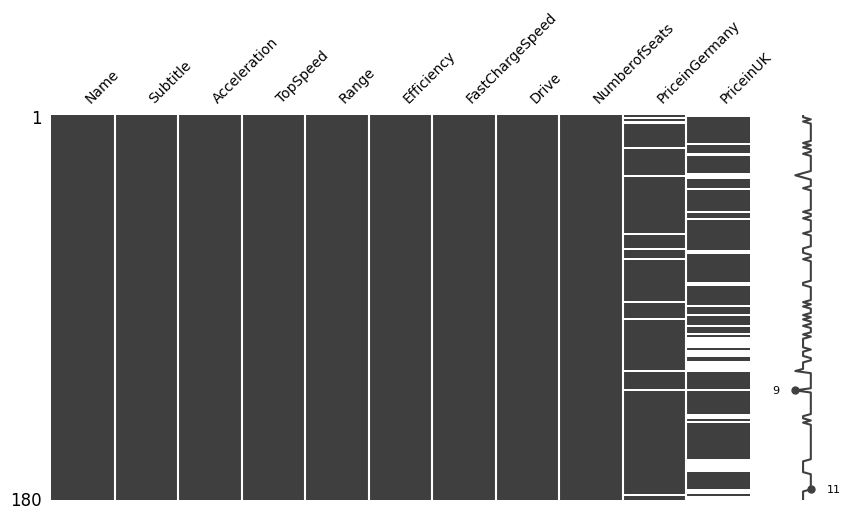

In [5]:
msno.matrix(df1,figsize=(10,5),fontsize=10)

In [12]:
# Removing currency symbols and convert price columns to numeric values
# Convert 'PriceinGermany' to string type before using .str
df1['PriceinGermany'] = pd.to_numeric(df1['PriceinGermany'].astype(str).str.replace('€', '').str.replace(',', ''), errors='coerce')
df1['PriceinUK'] = pd.to_numeric(df1['PriceinUK'].astype(str).str.replace('£', '').str.replace(',', ''), errors='coerce')

# Removing "km/h" or "km" from relevant columns and convert them to numeric
# Convert relevant columns to string type before using .str
df1['TopSpeed'] = pd.to_numeric(df1['TopSpeed'].astype(str).str.replace(' km/h', ''), errors='coerce')
df1['Range'] = pd.to_numeric(df1['Range'].astype(str).str.replace(' km', ''), errors='coerce')
df1['Efficiency'] = pd.to_numeric(df1['Efficiency'].astype(str).str.replace(' Wh/km', ''), errors='coerce')
df1['FastChargeSpeed'] = pd.to_numeric(df1['FastChargeSpeed'].astype(str).str.replace(' km/h', ''), errors='coerce')
# if priceis availale in germany but uk has NaN it will use that price to fill by conbverting german price to uk

df1['PriceinUK'] = df1['PriceinUK'].fillna(df1['PriceinGermany'] * 0.84)
# if both has NaN filling uk price with mean price
df1['PriceinUK'] = df1['PriceinUK'].fillna(df1['PriceinUK'].mean())
#fixing fast charging mising values with mean values

df1['FastChargeSpeed'] = df1['FastChargeSpeed'].fillna(df1['FastChargeSpeed'].mean())

df1.head()

,Name,Subtitle,Acceleration,TopSpeed,Range,Efficiency,FastChargeSpeed,Drive,NumberofSeats,PriceinGermany,PriceinUK
0,Opel Ampera-e,Battery Electric Vehicle | 58 kWh,7.3 sec,150,335,173,210.000000,Front Wheel Drive,5,42990.0,36111.6
1,Renault Kangoo Maxi ZE 33,Battery Electric Vehicle | 31 kWh,22.4 sec,130,160,194,481.257143,Front Wheel Drive,5,NaN,31680.0
2,Nissan Leaf,Battery Electric Vehicle | 36 kWh,7.9 sec,144,220,164,230.000000,Front Wheel Drive,5,29990.0,25995.0
3,Audi e-tron Sportback 55 quattro,Battery Electric Vehicle | 86.5 kWh,5.7 sec,200,375,231,600.000000,All Wheel Drive,5,NaN,79900.0
4,Porsche Taycan Turbo S,Battery Electric Vehicle | 83.7 kWh,2.8 sec,260,390,215,860.000000,All Wheel Drive,4,186336.0,138830.0


<Axes: >

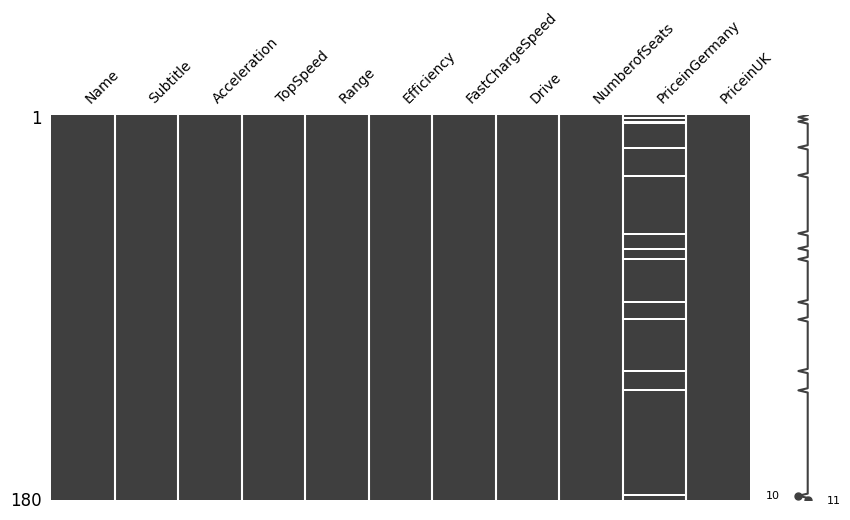

In [13]:
msno.matrix(df1,figsize=(10,5),fontsize=10)

In [14]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             180 non-null    object 
 1   Subtitle         180 non-null    object 
 2   Acceleration     180 non-null    object 
 3   TopSpeed         180 non-null    int64  
 4   Range            180 non-null    int64  
 5   Efficiency       180 non-null    int64  
 6   FastChargeSpeed  180 non-null    float64
 7   Drive            180 non-null    object 
 8   NumberofSeats    180 non-null    int64  
 9   PriceinGermany   168 non-null    float64
 10  PriceinUK        180 non-null    float64
dtypes: float64(3), int64(4), object(4)
memory usage: 15.6+ KB


**loading dataset 2**


In [15]:
url = "https://raw.githubusercontent.com/awais345/Electric-vehicles/main/Electric%20Car.csv"
df2 = pd.read_csv(url)
df2.head()

,Brand,Model,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,RapidCharge,PowerTrain,PlugType,BodyStyle,Segment,Seats,PriceEuro
0,Tesla,Model 3 Long Range Dual Motor,4.6,233,450,161,940,Yes,AWD,Type 2 CCS,Sedan,D,5,55480
1,Volkswagen,ID.3 Pure,10.0,160,270,167,250,Yes,RWD,Type 2 CCS,Hatchback,C,5,30000
2,Polestar,2,4.7,210,400,181,620,Yes,AWD,Type 2 CCS,Liftback,D,5,56440
3,BMW,iX3,6.8,180,360,206,560,Yes,RWD,Type 2 CCS,SUV,D,5,68040
4,Honda,e,9.5,145,170,168,190,Yes,RWD,Type 2 CCS,Hatchback,B,4,32997


In [16]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Brand            103 non-null    object 
 1   Model            103 non-null    object 
 2   AccelSec         103 non-null    float64
 3   TopSpeed_KmH     103 non-null    int64  
 4   Range_Km         103 non-null    int64  
 5   Efficiency_WhKm  103 non-null    int64  
 6   FastCharge_KmH   103 non-null    object 
 7   RapidCharge      103 non-null    object 
 8   PowerTrain       103 non-null    object 
 9   PlugType         103 non-null    object 
 10  BodyStyle        103 non-null    object 
 11  Segment          103 non-null    object 
 12  Seats            103 non-null    int64  
 13  PriceEuro        103 non-null    int64  
dtypes: float64(1), int64(5), object(8)
memory usage: 11.4+ KB


<Axes: >

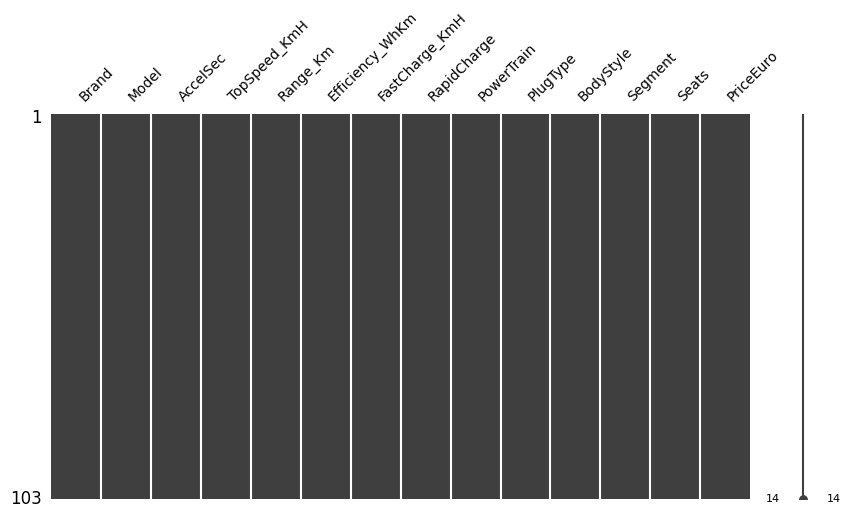

In [17]:
msno.matrix(df2,figsize=(10,5),fontsize=10)

**Merging the datasets to create 1 big dataset**


In [18]:

# we note that 2 columns merged can make name column of df1 from df2
# so 'Name' column in df2 is made by combining 'Brand' and 'Model'
df2['Name'] = df2['Brand'] + " " + df2['Model']

#  Renaming the  df2 columns to match with df1
df2_renamed = df2.rename(columns={
    'AccelSec': 'Acceleration',
    'TopSpeed_KmH': 'TopSpeed',
    'Range_Km': 'Range',
    'Efficiency_WhKm': 'Efficiency',
    'FastCharge_KmH': 'FastChargeSpeed',
    'Seats': 'NumberofSeats',
    'PriceEuro': 'PriceinEuro'
})

# now we have  matching columns in both datsets with equal type of units
# converting the Price in Euro to UK pound ( 1 Euro = 0.84 )
df2_renamed['PriceinUK'] = df2_renamed['PriceinEuro'] * 0.84

#  also Renaming the  df1 columns to match with df1
df2_final = df2_renamed[['Name', 'Acceleration', 'TopSpeed', 'Range', 'Efficiency', 'FastChargeSpeed', 'NumberofSeats', 'PriceinUK']]
print(df2_final.head())
# using only matching columns from df1
df1_final = df1[['Name', 'Acceleration', 'TopSpeed', 'Range', 'Efficiency', 'FastChargeSpeed', 'NumberofSeats', 'PriceinUK']]
print(df1_final.head())
# merging both columns
df = pd.concat([df1_final, df2_final], ignore_index=True)


print(df.info())

                                   Name  Acceleration  TopSpeed  Range  \
0  Tesla  Model 3 Long Range Dual Motor           4.6       233    450   
1                 Volkswagen  ID.3 Pure          10.0       160    270   
2                           Polestar  2           4.7       210    400   
3                             BMW  iX3            6.8       180    360   
4                             Honda  e            9.5       145    170   

   Efficiency FastChargeSpeed  NumberofSeats  PriceinUK  
0         161             940              5   46603.20  
1         167             250              5   25200.00  
2         181             620              5   47409.60  
3         206             560              5   57153.60  
4         168             190              4   27717.48  
                               Name Acceleration  TopSpeed  Range  Efficiency  \
0                    Opel Ampera-e       7.3 sec       150    335         173   
1         Renault Kangoo Maxi ZE 33     22.4 

In [19]:
df

,Name,Acceleration,TopSpeed,Range,Efficiency,FastChargeSpeed,NumberofSeats,PriceinUK
0,Opel Ampera-e,7.3 sec,150,335,173,210.0,5,36111.6
1,Renault Kangoo Maxi ZE 33,22.4 sec,130,160,194,481.257143,5,31680.0
2,Nissan Leaf,7.9 sec,144,220,164,230.0,5,25995.0
3,Audi e-tron Sportback 55 quattro,5.7 sec,200,375,231,600.0,5,79900.0
4,Porsche Taycan Turbo S,2.8 sec,260,390,215,860.0,4,138830.0
...,...,...,...,...,...,...,...,...
278,Nissan Ariya 63kWh,7.5,160,330,191,440,5,37800.0
279,Audi e-tron S Sportback 55 quattro,4.5,210,335,258,540,5,80682.0
280,Nissan Ariya e-4ORCE 63kWh,5.9,200,325,194,440,5,42000.0
281,Nissan Ariya e-4ORCE 87kWh Performance,5.1,200,375,232,450,5,54600.0


**EDA**

<Axes: >

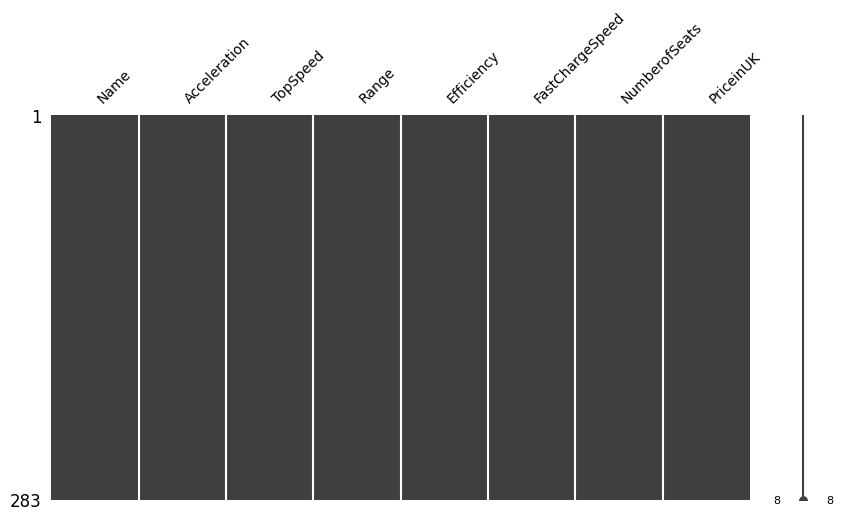

In [20]:
# checking for the missing values for the merged dataset

msno.matrix(df,figsize=(10,5),fontsize=10)

<Axes: >

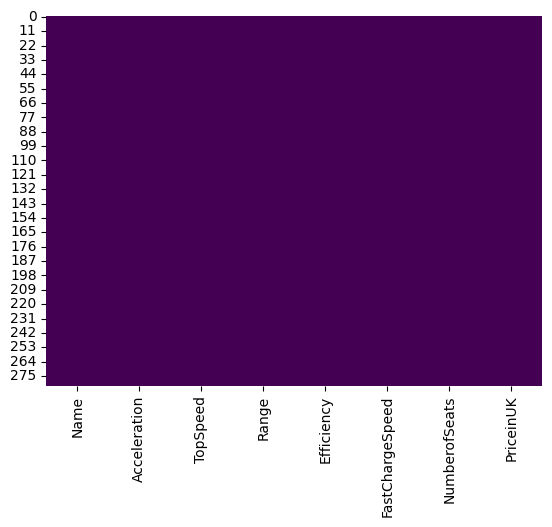

In [21]:
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')

In [22]:
print(df.describe())

         TopSpeed       Range  Efficiency  NumberofSeats      PriceinUK
count  283.000000  283.000000  283.000000     283.000000     283.000000
mean   177.416961  337.897527  192.413428       5.063604   49277.537831
std     42.583701  121.203686   31.627970       0.920328   27418.283087
min    123.000000   95.000000  104.000000       2.000000   16908.360000
25%    150.000000  255.000000  168.000000       5.000000   30472.500000
50%    160.000000  340.000000  184.000000       5.000000   42250.000000
75%    200.000000  400.000000  209.000000       5.000000   57091.800000
max    410.000000  970.000000  281.000000       7.000000  189000.000000


In [23]:
# Distribution of categorical columns
print(df['Name'].value_counts())
print(df['Acceleration'].value_counts())
print(df['FastChargeSpeed'].value_counts())

Name
Audi e-tron 55 quattro                 2
Audi e-tron Sportback 55 quattro       2
Tesla Model 3 Long Range Dual Motor    2
Hyundai Kona Electric 64 kWh           2
Kia e-Soul 64 kWh                      2
                                      ..
Citroen e-SpaceTourer XS 50 kWh        1
Citroen e-SpaceTourer M 50 kWh         1
Citroen e-SpaceTourer XL 50 kWh        1
Citroen e-SpaceTourer M 75 kWh         1
Byton  M-Byte 95 kWh 2WD               1
Name: count, Length: 276, dtype: int64
Acceleration
12.1 sec    11
9.0 sec      8
8.5 sec      8
7.9 sec      7
9.0          7
            ..
3.0 sec      1
4.7          1
12.6 sec     1
8.6 sec      1
5.9          1
Name: count, Length: 132, dtype: int64
FastChargeSpeed
440.0    9
250.0    8
290.0    8
420.0    6
230      6
        ..
180.0    1
910.0    1
780      1
930      1
500      1
Name: count, Length: 120, dtype: int64


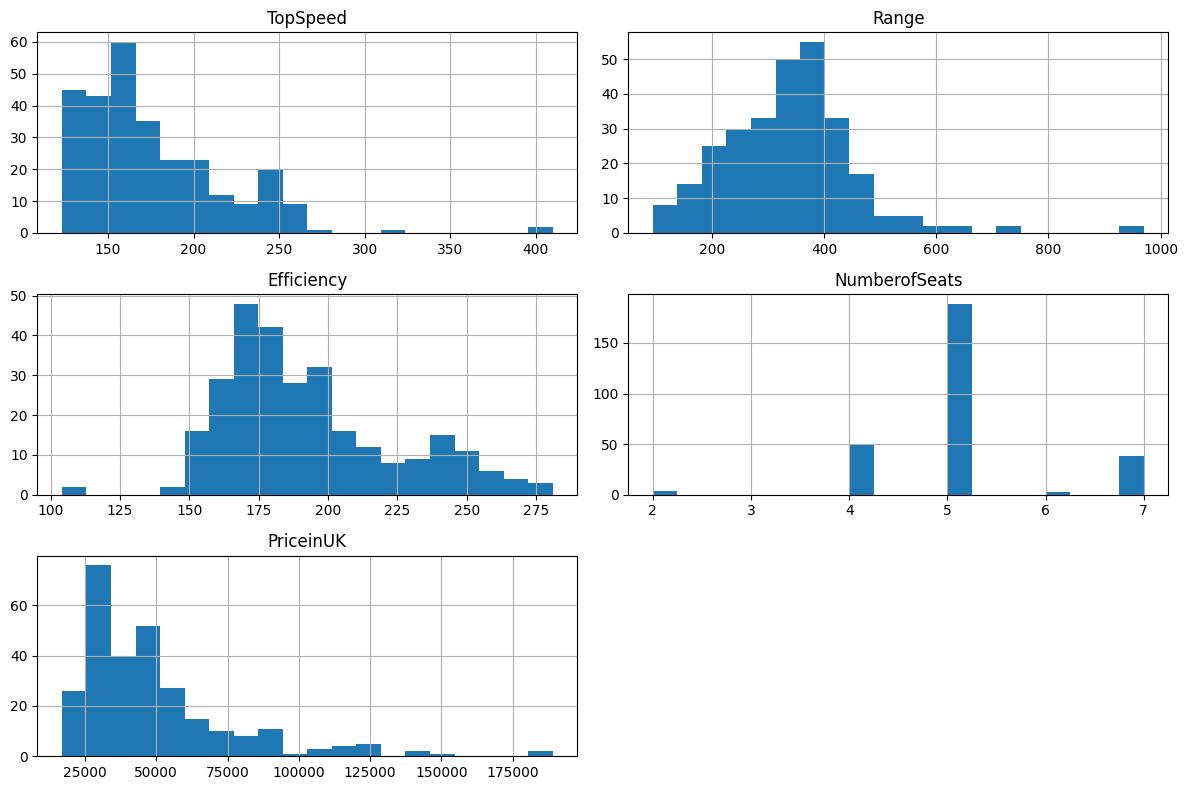

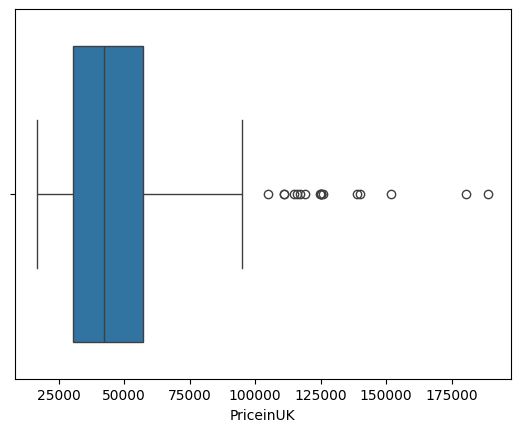

In [27]:
# Histogram for numerical columns
numerical_columns = ['TopSpeed', 'Range', 'Efficiency', 'NumberofSeats', 'PriceinUK']
df[numerical_columns].hist(bins=20, figsize=(12, 8))
plt.tight_layout()
plt.show()

# Box plot for PriceinUK
sns.boxplot(x=df['PriceinUK'])
plt.show()

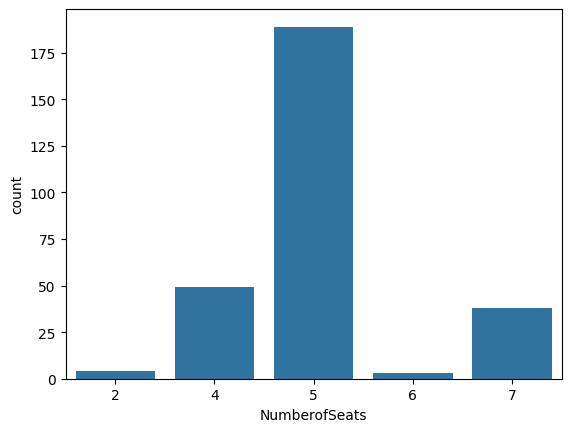

In [28]:
# Bar plot for 'NumberofSeats'
sns.countplot(x='NumberofSeats', data=df)
plt.show()

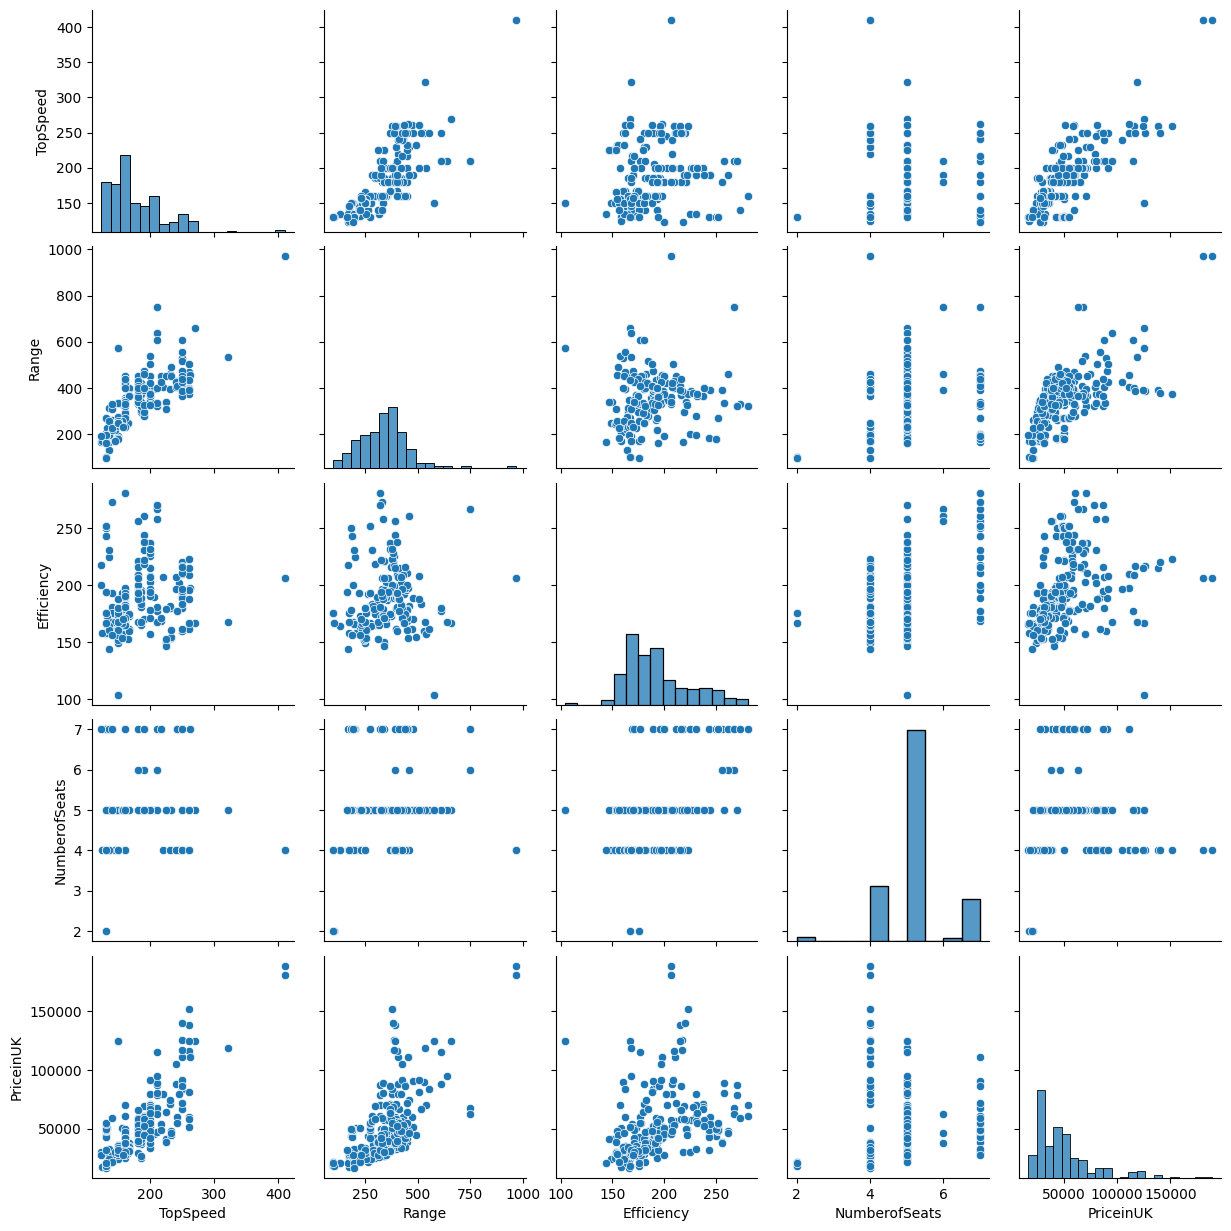

In [29]:
# Pairplot for numerical columns
sns.pairplot(df[numerical_columns])
plt.show()

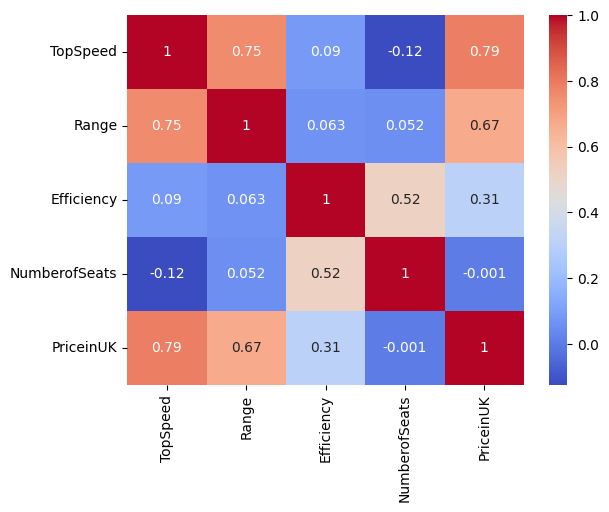

In [30]:
# Correlation heatmap
corr = df[numerical_columns].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

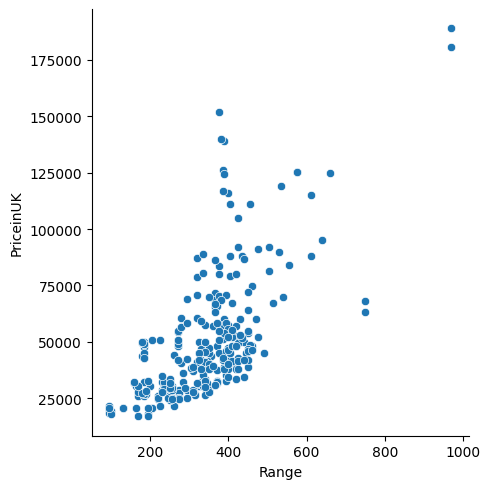

In [31]:
sns.relplot(x='Range', y='PriceinUK', data=df)

**Feature Egineering**

In [32]:
# removing non numeric units
df['Acceleration'] = df['Acceleration'].str.replace(' sec', '', regex=False).astype(float)

df['FastChargeSpeed'] = pd.to_numeric(df['FastChargeSpeed'], errors='coerce')
# droping the name and target column as the name brand impact is unpredictable
X = df.drop(columns=['Name', 'PriceinUK'])

# seting the target variable
y = df['PriceinUK']

<Axes: xlabel='None'>

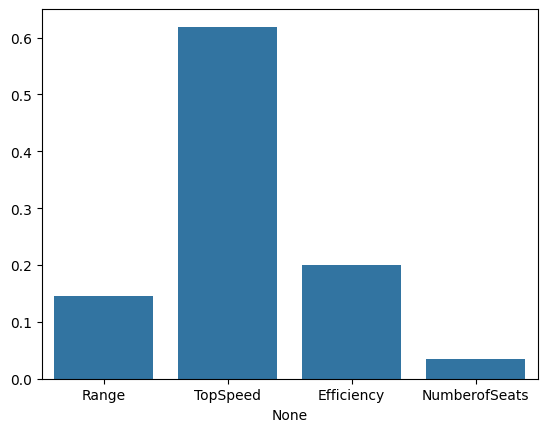

In [33]:
X = df[['Range', 'TopSpeed', 'Efficiency', 'NumberofSeats']]
y = df['PriceinUK']

model = RandomForestRegressor()
model.fit(X, y)

# Ploting feature importance using RF-regressor
importance = model.feature_importances_
sns.barplot(x=X.columns, y=importance)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283 entries, 0 to 282
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             283 non-null    object 
 1   Acceleration     180 non-null    float64
 2   TopSpeed         283 non-null    int64  
 3   Range            283 non-null    int64  
 4   Efficiency       283 non-null    int64  
 5   FastChargeSpeed  278 non-null    float64
 6   NumberofSeats    283 non-null    int64  
 7   PriceinUK        283 non-null    float64
dtypes: float64(3), int64(4), object(1)
memory usage: 17.8+ KB


In [35]:
df.columns

Index(['Name', 'Acceleration', 'TopSpeed', 'Range', 'Efficiency',
       'FastChargeSpeed', 'NumberofSeats', 'PriceinUK'],
      dtype='object')

In [36]:
X = df.drop(columns=['Name', 'PriceinUK'])
y = df['PriceinUK']


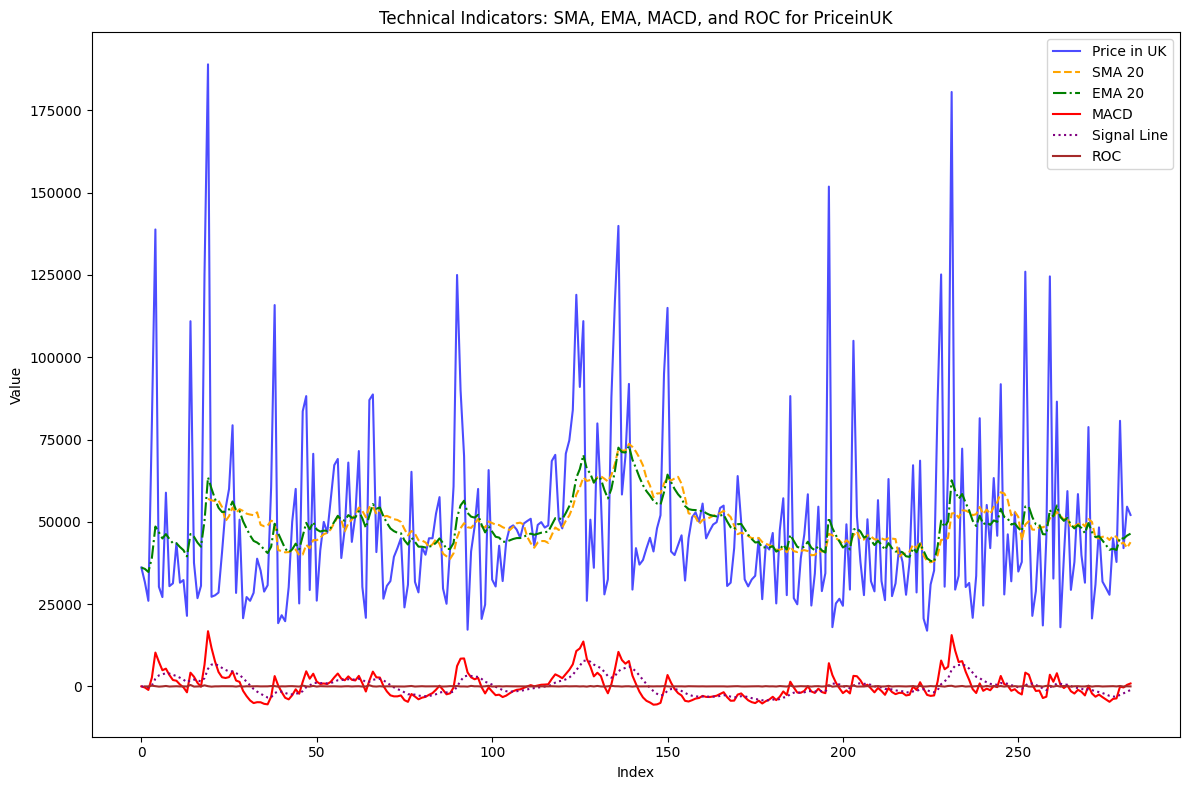

In [37]:
# Feature Engineering: SMA, EMA, MACD, ROC
# PriceinUK is oir feature for the indicators

# Calculating Simple Moving Average (SMA)
df['SMA_20'] = df['PriceinUK'].rolling(window=20).mean()  # 20-period SMA

# Calculating Exponential Moving Average (EMA)
df['EMA_20'] = df['PriceinUK'].ewm(span=20, adjust=False).mean()  # 20-period EMA

# Calculating MACD (Moving Average Convergence Divergence)
# Fast EMA (12-period)
df['EMA_12'] = df['PriceinUK'].ewm(span=12, adjust=False).mean()
# Slow EMA (26-period)
df['EMA_26'] = df['PriceinUK'].ewm(span=26, adjust=False).mean()
# MACD Line
df['MACD'] = df['EMA_12'] - df['EMA_26']
# Signal Line (9-period EMA of MACD)
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()


# Calculating Rate of Change (ROC)
# 1-period ROC in percentage
df['ROC'] = df['PriceinUK'].pct_change(periods=1) * 100

# Ploting all indicators in a single plot
plt.figure(figsize=(12, 8))

# Ploting the original PriceinUK
plt.plot(df['PriceinUK'], label='Price in UK', color='blue', alpha=0.7)

# Ploting SMA and EMA
plt.plot(df['SMA_20'], label='SMA 20', color='orange', linestyle='--')
plt.plot(df['EMA_20'], label='EMA 20', color='green', linestyle='-.')

# Ploting MACD and Signal Line
plt.plot(df['MACD'], label='MACD', color='red', linestyle='-')
plt.plot(df['Signal_Line'], label='Signal Line', color='purple', linestyle=':')

# Ploting ROC (Rate of Change)
plt.plot(df['ROC'], label='ROC', color='brown', linestyle='-')

# Setting t he plot title and labels
plt.title('Technical Indicators: SMA, EMA, MACD, and ROC for PriceinUK')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

**Random Forest**


In [38]:
def random_forest(ts,nst):

  # Spliting nin test train ratio
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)

  # Training the Random Forest Model
  rf_model = RandomForestRegressor(n_estimators=nst, random_state=42)
  rf_model.fit(X_train, y_train)

  # Predicting
  y_pred = rf_model.predict(X_test)

  # Evaluating the Model
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  rse = r2_score(y_test, y_pred)
  print("\n\n")
  print("-"*60)
  print("-"*60)
  print("Mean Absolute Error (MAE):", mae)
  print("Mean Squared Error (MSE):", mse)
  print("Root Mean Squared Error (RMSE):", rmse)
  print("R-Squared Score (R2SE):", rse)
  print("-"*60)
  print("-"*60)

  # Graph ploting
  plt.figure(figsize=(10, 6))
  plt.scatter(y_test, y_pred
              , alpha=0.5)
  plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
  plt.xlabel('Actual Prices')
  plt.ylabel('Predicted Prices')
  plt.title('Actual Prices vs. Predicted Prices')
  plt.show()
    # Error Distribution Plot
  residuals = y_test - y_pred
  plt.figure(figsize=(10, 6))
  sns.histplot(residuals, kde=True, bins=30, color='blue')
  plt.xlabel('Residuals (Errors)')
  plt.title('Error Distribution')
  plt.show()

  return rf_model




------------------------------------------------------------
------------------------------------------------------------
Mean Absolute Error (MAE): 5034.149452751051
Mean Squared Error (MSE): 62593911.31743695
Root Mean Squared Error (RMSE): 7911.631394183943
R-Squared Score (R2SE): 0.8723606518241187
------------------------------------------------------------
------------------------------------------------------------


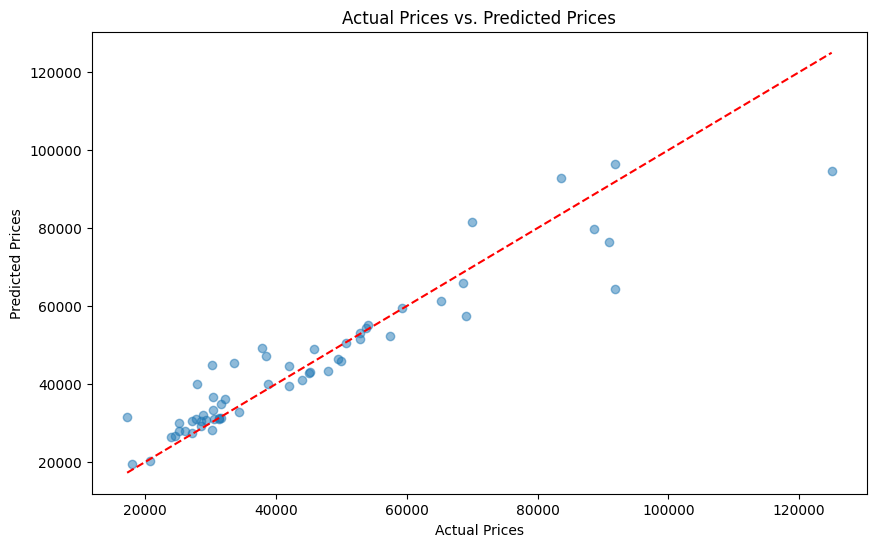

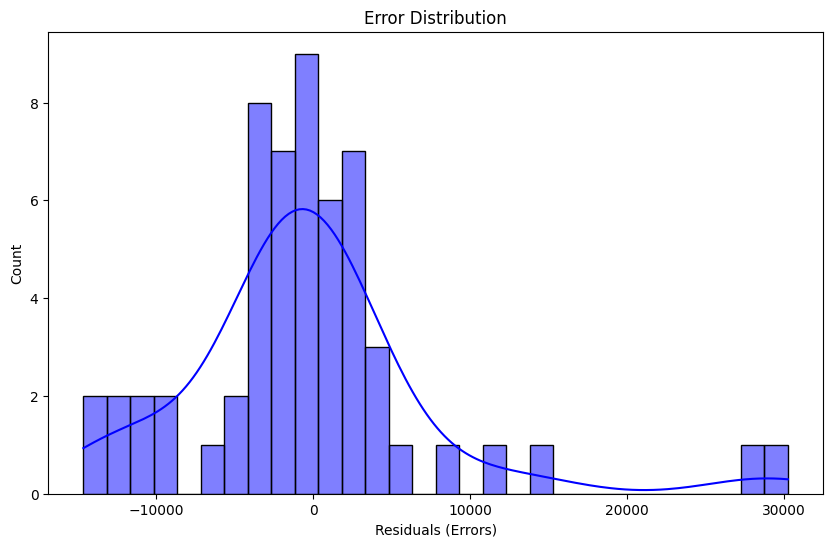

In [39]:
model = random_forest(ts=0.2,nst=100)

**Predicting The Price**


In [43]:
def predict_car_price(model, feature_order):
    print("Please enter the values for the following features:")

    try:

        top_speed = float(input("Enter the top speed (in km/h): "))
        range_km = float(input("Enter the range (in km): "))
        efficiency = float(input("Enter the efficiency (in Wh/km): "))
        fast_charge_speed = float(input("Enter the fast charge speed (in km/h): "))
        number_of_seats = int(input("Enter the number of seats: "))
        acceleration = float(input("Enter the acceleration (in seconds): "))

        # dictionary for input values
        input_data = {
            'TopSpeed': top_speed,
            'Range': range_km,
            'Efficiency': efficiency,
            'FastChargeSpeed': fast_charge_speed,
            'NumberofSeats': number_of_seats,
            'Acceleration': acceleration
        }


        input_df = pd.DataFrame([input_data])

        # matching the feature
        input_df = input_df[feature_order]

        # error tackling
        print("\nInput Data for Prediction:\n", input_df)

        # Predicting the price
        predicted_price = model.predict(input_df)[0]
        print(f"\nThe predicted price of the car is: €{predicted_price:,.2f}")

    except ValueError as ve:
        print(f"Input Error: {ve}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

In [44]:
predict_car_price(model, X.columns)

Please enter the values for the following features:
Enter the top speed (in km/h): 150
Enter the range (in km): 335
Enter the efficiency (in Wh/km): 173
Enter the fast charge speed (in km/h): 210
Enter the number of seats: 5
Enter the acceleration (in seconds): 7.3

Input Data for Prediction:
    Acceleration  TopSpeed  Range  Efficiency  FastChargeSpeed  NumberofSeats
0           7.3     150.0  335.0       173.0            210.0              5

The predicted price of the car is: €35,174.46
